# Hyperparameter Tuning with Optuna

Hyperparameters are **non-learnable parameters** of a model that determine its architecture. The correct choice of hyperparameters could mean the difference between convergence to or divergence from a solution. In this notebook, we explore an open-source library that provides a framework for solving this task. From its docs:

> **Optuna** is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, *define-by-run* style user API. Thanks to our *define-by-run* API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.


- [Optuna FAQ](https://optuna.readthedocs.io/en/stable/faq.html)
- [Optuna docs](https://optuna.readthedocs.io/en/stable/index.html#)
- [Optuna paper](https://arxiv.org/abs/1907.10902)

In [ ]:
# Experiment config
RF_NTRIALS = 60
VGG_NTRIALS = 40
CIFAR10_SAMPLE_RATIO = 0.5
CIFAR10_RESIZE = 32

## Basics with scikit-learn

Optuna is a black-box optimizer, which means it only needs an objective function (any function that returns a numerical value) to evaluate the performance of the its parameters, and decide where to sample in upcoming trials. An optimization problem is framed in the Optuna API using two basic concepts: `study` and `trial`. 

A study is conceptually an optimization based on an objective function, while a trial is a single execution of an objective function. The combination of hyperparameters for each trial is sampled according to some sampling algorithm defined by the study. 

In the following code example, the search space is constructed within imperative Python code, e.g. inside conditionals or loops. On the other hand, recall that for `GridSearchCV` and `RandomSearchCV` in scikit-learn, we had to define the entire search space before running the search algorithm.

```{caution}
Always perform model evaluation on a dataset within a cross-validation framework!
```

In [2]:
import optuna
import pandas as pd
from sklearn import ensemble, svm
from sklearn import datasets
from sklearn import model_selection
from functools import partial
import joblib


# (1) Define an objective function to be maximized.
def objective(trial, X, y):
    
    # (2) Suggest values for the hyperparameters using trial object.
    clf_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if clf_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        clf = svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        clf = ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()

# (3) Create a study object and optimize the objective function.
X, y = datasets.load_breast_cancer(return_X_y=True)
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, X=X, y=y), n_trials=5)

[I 2022-01-09 16:43:23,964] A new study created in memory with name: no-name-54f1a555-fa15-42c3-8253-bf2ed881f9d2
[I 2022-01-09 16:43:26,066] Trial 0 finished with value: 0.9490607048594939 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 17.073087050633617}. Best is trial 0 with value: 0.9490607048594939.
[I 2022-01-09 16:43:26,171] Trial 1 finished with value: 0.9542928116752056 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 13.974140377683506}. Best is trial 1 with value: 0.9542928116752056.
[I 2022-01-09 16:43:26,250] Trial 2 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 181956.84041464477}. Best is trial 1 with value: 0.9542928116752056.
[I 2022-01-09 16:43:26,330] Trial 3 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 864898.4184373791}. Best is trial 1 with value: 0.9542928116752056.
[I 2022-01-09 16:43:26,432] Trial 4 finished with value: 0.9613569321533924 and paramet

The `study` object saves the result of evaluating the objective each trial &mdash; which is essentially some choice of hyperparameters to evaluate. In the above study, the problem of model selection is framed as a hyperparameter optimization problem. Here we choose between an SVM-based algorithm or Random Forest.

In [3]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_rf_max_depth,params_svc_c,state
0,0,0.949061,2022-01-09 16:43:23.966991,2022-01-09 16:43:26.066287,0 days 00:00:02.099296,RandomForest,17.073087,NaN,COMPLETE
1,1,0.954293,2022-01-09 16:43:26.068106,2022-01-09 16:43:26.171510,0 days 00:00:00.103404,RandomForest,13.974140,NaN,COMPLETE
2,2,0.627418,2022-01-09 16:43:26.172781,2022-01-09 16:43:26.250413,0 days 00:00:00.077632,SVC,NaN,181956.840415,COMPLETE
3,3,0.627418,2022-01-09 16:43:26.251880,2022-01-09 16:43:26.329750,0 days 00:00:00.077870,SVC,NaN,864898.418437,COMPLETE
4,4,0.961357,2022-01-09 16:43:26.331104,2022-01-09 16:43:26.432237,0 days 00:00:00.101133,RandomForest,9.727522,NaN,COMPLETE


### Fine tuning Random Forest

Here we focus on tuning a single Random Forest model. Then, plot the accuracy for each pair of hyperparameters.

In [4]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 128, log=True)    
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 800, log=True)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = ensemble.RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features,
        criterion=criterion,
        random_state=42)   
    
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=RF_NTRIALS)

[I 2022-01-09 16:43:26,890] A new study created in memory with name: no-name-115a68d2-ab3d-4fb7-863e-40264b640ac5
[I 2022-01-09 16:43:31,170] Trial 0 finished with value: 0.9666356155876418 and parameters: {'max_depth': 70, 'max_features': 0.4553140329238048, 'n_estimators': 353, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9666356155876418.
[I 2022-01-09 16:43:33,757] Trial 1 finished with value: 0.9490607048594939 and parameters: {'max_depth': 2, 'max_features': 0.8793554962469481, 'n_estimators': 217, 'criterion': 'gini'}. Best is trial 0 with value: 0.9666356155876418.
[I 2022-01-09 16:43:46,501] Trial 2 finished with value: 0.9648657040832169 and parameters: {'max_depth': 112, 'max_features': 0.8957261207990624, 'n_estimators': 679, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9666356155876418.
[I 2022-01-09 16:43:51,862] Trial 3 finished with value: 0.95960254618848 and parameters: {'max_depth': 52, 'max_features': 0.131096167102392, 'n_estimators': 688, 'crit

In [5]:
study.best_params

{'max_depth': 28,
 'max_features': 0.4278318142755836,
 'n_estimators': 596,
 'criterion': 'entropy'}

In [6]:
study.best_value

0.9701443875174661

### Sampling algorithms

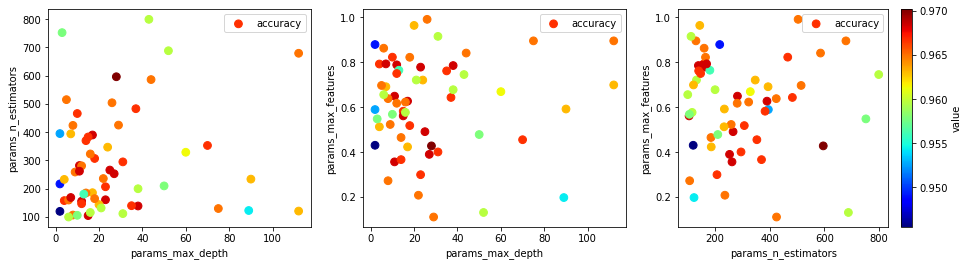

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3)

def plot_results(study, p1, p2, j, cb):
    study.trials_dataframe().plot(
        kind='scatter', ax=axes[j], x=p1, y=p2,
        c='value', s=60, cmap=plt.get_cmap("jet"), 
        colorbar=cb, label="accuracy", figsize=(16, 4)
    )

plot_results(study, 'params_max_depth',    'params_n_estimators', j=0, cb=False)
plot_results(study, 'params_max_depth',    'params_max_features', j=1, cb=False)
plot_results(study, 'params_n_estimators', 'params_max_features', j=2, cb=True);

**Figure.** TPE in action. Optuna uses  **Tree-structured Parzen Estimater (TPE)** {cite}`bergstra` as the default sampler which is a form of Bayesian optimization. Observe that the hyperparameter space is searched more efficiently than random search with the sampler choosing points closer to previous good results. Samplers are specified when creating a study: 

```python
study = create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
```

From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler):

> On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) `l(x)` to the set of parameter values associated with the best objective values, and another GMM `g(x)` to the remaining parameter values. It chooses the parameter value `x` that maximizes the ratio `l(x)/g(x)`.

Thus, TPE samples every hyperparameter **independently** &mdash; no explicit hyperparameter interactions are considered when sampling future trials, although other parameters implicitly affect objective value. Optuna also implements our old friends random and grid search in the following samplers:
- `optuna.samplers.GridSampler`
- `optuna.samplers.RandomSampler`

Another sampling algorithm implemented in Optuna is **Covariance Matrix Adaptation Evolution Strategy (CMA-ES)** {cite}`hansen2016cma`. This algorithm is designed to tackle ill-conditioned, non-separable problems, i.e. cannot be solved by solving several 1-dimensional problems. CMA-ES is typically implemented along with TPE whenever the former algorithm is not applicable, e.g. for searching dynamically constructed hyperparameters (as CMA-ES requires that parameters are specified statically prior to the optimization) or for searching categorical parameters, as CMA-ES is designed to search real parameters on a continuous domain. TPE+CMA-ES sampling can be implemented as follows:

```python
sampler = optuna.samplers.CmaEsSampler(
    warn_independent_sampling=False,
    independent_sampler=optuna.samplers.TPESampler()
)
```

Results from the paper {cite}`akiba2019optuna` show that TPE+CMA-ES works better than counterparts of the same time complexity:

```{figure} ../img/fig9-optuna.png
---
width: 35em
name: fig9-optuna
---
```

```{figure} ../img/fig10-optuna.png
---
width: 35em
name: fig10-optuna
---
```

```{figure} ../img/optuna-results.png
---
width: 35em
name: optuna-results
---
```

### Visualizing Results

Optuna provides visualization functions in the `optuna.visualization` library [^ref4]. The following plot shows the best objective value found as the trials progress. The increasing trend in accuracy indicates that the TPE sampler is working well, i.e. the search algorithm learns from previous trials.

[^ref4]: See [Optuna dashboard](https://github.com/optuna/optuna-dashboard) which displays the same plots that are updated in real-time.

In [8]:
optuna.visualization.plot_optimization_history(study)

The **parallel coordinate plot** gives us a feel of how the hyperparameters interact. To isolate subsets of lines, we can use the interactive capabilities of the plots by dragging on each axis to restrict it. The resulting purple bars can be disjoint.

In [9]:
optuna.visualization.plot_parallel_coordinate(study)

The following **slice plots** show the projections of the sampler's path in the hyperparameter space in each individual dimension, then shifts each point along the vertical axis based on the its objective value. 

In [10]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=900, height=400)

The default **hyperparameter importance evaluator** in Optuna is `FanovaImportanceEvaluator`. This takes as input performance data gathered with different hyperparameter settings of the algorithm, fits a random forest to capture the relationship between hyperparameters and performance, and then applies functional ANOVA to assess how important each of the hyperparameters and each low-order interaction of hyperparameters is to performance {cite}`pmlr-v32-hutter14`. From the [docs](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html):

> The performance of fANOVA depends on the prediction performance of the underlying random forest model. In order to obtain high prediction performance, it is necessary to cover a wide range of the hyperparameter search space. It is recommended to use an exploration-oriented sampler such as `RandomSampler`.

In [11]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=600, height=350)
fig.show()

To visualize interactions between any pair of hyperparameters, we can generate **contour plots** where regions of *low* objective value are darker in color.

In [12]:
fig = optuna.visualization.plot_contour(study, params=["criterion", "n_estimators"])
fig.update_layout(width=600, height=500)

## Neural networks

As noted above, we should always perform tuning within a cross-validation framework. However, with neural networks, doing 5-fold CV would require too much compute time &mdash; hence, too much resources, e.g. GPU usage. Instead, we perform tuning on a hold-out validation set and hope for the best. 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils import data

from tqdm import tqdm
import optuna
import numpy as np

PATIENCE = 5
EPOCHS = 100
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Define a convolutional network with a smaller version of the VGG architecture.

In [14]:
# https://d2l.ai/chapter_convolutional-modern/vgg.html

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)


def vgg(conv_arch, linear_width, dropout, in_channels=3):
    conv_blks = []
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    height, width = 6, 6
    dense_layers = [
        nn.AdaptiveAvgPool2d((height, width)),
        nn.Flatten(),
        nn.Linear(out_channels * height * width, linear_width),
        nn.ReLU(), nn.Dropout(dropout),
        nn.Linear(linear_width, linear_width),
        nn.ReLU(), nn.Dropout(dropout),
        nn.Linear(linear_width, 10)
    ]
    return nn.Sequential(*(conv_blks + dense_layers))

We also define a `Dataset` class for CIFAR-10.

In [15]:
transform = [transforms.ToTensor()]
if CIFAR10_RESIZE:
    transform.insert(0, transforms.Resize(CIFAR10_RESIZE))
transform = transforms.Compose(transform)

mnist_train = datasets.CIFAR10(root=".", train=True,  transform=transform, download=True)
mnist_valid = datasets.CIFAR10(root=".", train=False, transform=transform, download=True)


def get_cifar10_dataloaders(batch_size, resize, sample_ratio=1.0):
    train_loader = data.DataLoader(mnist_train, 
                                   batch_size, 
                                   drop_last=True, 
                                   sampler=range(int(len(mnist_train)*sample_ratio)))
    
    valid_loader = data.DataLoader(mnist_valid, 
                                   batch_size, 
                                   drop_last=True, 
                                   sampler=range(int(len(mnist_valid)*sample_ratio)))
    
    return train_loader, valid_loader

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Define a trainer for the neural network model. This will handle all loss and metric evaluation, as well as backpropagation.

In [16]:
class Engine:
    """Facilitate neural network training and evaluation."""
    
    def __init__(self, model, device, optimizer):
        self.model = model
        self.device = device
        self.optimizer = optimizer 

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
        
    def train(self, data_loader):
        """Train model on one epoch. Return train loss."""
        
        self.model.train()
        loss = 0
        for i, (data, targets) in enumerate(data_loader):
            data = data.to(self.device).float()
            targets = targets.to(self.device).long()
            
            # Forward pass
            outputs = self.model(data)
            J = self.loss_fn(outputs, targets)
            
            # Backward pass
            self.optimizer.zero_grad()
            J.backward()
            self.optimizer.step()

            # Cumulative loss
            loss += (J.detach().item() - loss) / (i + 1)

        return loss


    def eval(self, data_loader):
        """Return validation loss and validation accuracy."""
        
        self.model.eval()
        num_correct = 0
        num_samples = 0
        loss = 0.0
        with torch.no_grad():
            for i, (data, targets) in enumerate(data_loader):
                data = data.to(self.device).float()
                targets = targets.to(self.device)
                
                # Forward pass
                out = self.model(data)
                J = self.loss_fn(out, targets)
                _, preds = out.max(dim=1)

                # Cumulative metrics
                loss += (J.detach().item() - loss) / (i + 1)
                num_correct += (preds == targets).sum().item()
                num_samples += preds.shape[0]

        acc = num_correct / num_samples
        return loss, acc

### Pruning based on intermediate values

Finally, we set up the `study` instance and its objective function. Note that the search space is dynamically constructed depending on the number of layers (i.e. an earlier suggestion for a hyperparameter). During training, we perform early stopping on validation loss. If no new minimum val. loss is found after 5 epochs, then the minimum val. loss is returned as the objective [^ref3].

Computing intermediate values allow us to **prune** unpromising trials to conserve resources. The default pruner in Optuna is [`MedianPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html) which prunes a trial if its best intermediate result as of the current step (e.g. current best valid loss) is worse than the median of all intermediate results of previous trials *at the current step*. Hence, the best intermediate result of a pruned trial is less than the best intermediate result of 1/2 of the other trials as of that step. In our case, if the minimum validation loss does not improve too quickly, then the trial is pruned. Of course, the validation loss could descend rapidly at later steps, but the median pruner does not bet on this happening.

[^ref3]: In practice, we save the best model parameters at this point.

In [17]:
def run_training(trial, train_loader, valid_loader, engine):
    # Run training
    best_loss = np.inf
    patience = PATIENCE
    loop = tqdm(range(EPOCHS), total=EPOCHS, leave=False)
    for epoch in loop:

        # Train and validation step
        train_loss = engine.train(train_loader)
        valid_loss, valid_acc = engine.eval(valid_loader)
            
        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break
    
        # Pruning unpromising trials
        trial.report(valid_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}]")
        loop.set_postfix(
            val_loss=valid_loss, 
            acc=valid_acc, 
            patience=patience,
            lr=engine.optimizer.param_groups[0]['lr'])
        
    return best_loss


def objective(trial):
    # Setup model architecture
    conv_arch = [
        (1, trial.suggest_int(f"vgg_b1", 128, 512, log=True)),
        (2, trial.suggest_int(f"vgg_b2", 128, 512, log=True)),
        (2, trial.suggest_int(f"vgg_b3", 128, 512, log=True)),
    ]
    dense_width = trial.suggest_int("dense", 256, 1024, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 1.0, step=0.1)
    learning_rate = trial.suggest_float("lr", 1e-5, 0.3, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)

    # Initialize engine
    model = vgg(conv_arch, dense_width, dropout).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)    
    engine = Engine(model, DEVICE, optimizer)
    
    # Initalize data loaders
    train_loader, valid_loader = get_cifar10_dataloaders(batch_size, resize=28, sample_ratio=CIFAR10_SAMPLE_RATIO)
    
    # Start training run
    score = run_training(trial, train_loader, valid_loader, engine)
    return score

This study looks rather complicated, with a lot of moving parts. We can test the objective using a `FixedTrial` which suggests fixed parameter values based on a given dictionary of parameters:

```python
trial = FixedTrial(param_dict)
objective(trial) 
```

We now create the minimization problem with median pruner. The parameters of the pruner will be explained below.

In [18]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=15, n_min_trials=5)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=VGG_NTRIALS)

[I 2022-01-09 16:47:49,141] A new study created in memory with name: no-name-78b4e217-1a91-4764-8134-993f98d3cea7
[I 2022-01-09 16:54:25,197] Trial 0 finished with value: 0.9663325294852255 and parameters: {'vgg_b1': 310, 'vgg_b2': 162, 'vgg_b3': 289, 'dense': 598, 'dropout': 0.1, 'lr': 5.8571334191863526e-05, 'batch_size': 124}. Best is trial 0 with value: 0.9663325294852255.
[I 2022-01-09 17:01:53,776] Trial 1 finished with value: 0.8538003005400426 and parameters: {'vgg_b1': 258, 'vgg_b2': 247, 'vgg_b3': 206, 'dense': 402, 'dropout': 0.7000000000000001, 'lr': 5.986375901071346e-05, 'batch_size': 42}. Best is trial 1 with value: 0.8538003005400426.
[I 2022-01-09 17:06:12,651] Trial 2 finished with value: 0.9333370736837385 and parameters: {'vgg_b1': 249, 'vgg_b2': 160, 'vgg_b3': 291, 'dense': 960, 'dropout': 0.5, 'lr': 9.652575464574833e-05, 'batch_size': 20}. Best is trial 1 with value: 0.8538003005400426.
[I 2022-01-09 17:07:29,117] Trial 3 finished with value: 2.308023227112635 an

In [19]:
from optuna.trial import TrialState

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials:\t", len(study.trials))
print("  Number of pruned trials:\t", len(pruned_trials))
print("  Number of complete trials:\t", len(complete_trials))

print("\nBest trial:")
best_trial = study.best_trial

print("  Value: ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:	 40
  Number of pruned trials:	 10
  Number of complete trials:	 30

Best trial:
  Value:  0.8468572935637306
  Params: 
    vgg_b1: 138
    vgg_b2: 141
    vgg_b3: 250
    dense: 852
    dropout: 0.7000000000000001
    lr: 9.058519215325063e-05
    batch_size: 49


Trials either early stops (gradient descent loses momentum) or gets pruned (expected to not improve even if gradient descent continues). Pruning starts after 10 trials are completed, i.e. `n_startup_trials=10`. This is so that the pruner obtains enough information about the general behavior of the gradient descent optimizer before starting to prune. We set `n_warmup_steps=15` allowing each trial to train the network for 16 epochs before pruning, so that the completed trials will not be dominated by networks that descend quickly, but to shallow minimas. For example, shallow networks that possibly overfits the validation set. However, this comes at the price of wasting resources for training 16 epochs for around half of the number of trials. Finally, we set `n_min_trials=5` so that a higher number of trials at later steps can continue until it early stops or reaches max epochs.

In [20]:
optuna.visualization.plot_intermediate_values(study)

In [21]:
optuna.visualization.plot_optimization_history(study)

We can look at the distribution of best losses. Should have used a higher number of bins!

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



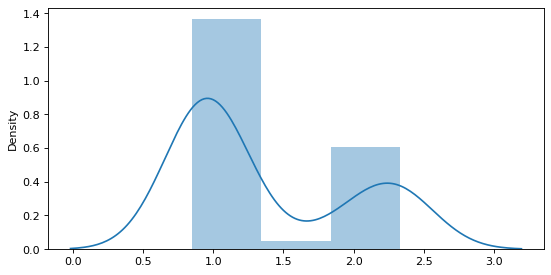

In [22]:
import seaborn as sns
plt.figure(figsize=(8, 4), dpi=80)
sns.distplot(study.trials_dataframe().value.values);

### Analyzing hyperparameter interactions

The parallel coordinate plot below shows which combination of hyperparameters work. We can also use this to select low complexity models with similar performance to the best performance. 

In [23]:
optuna.visualization.plot_parallel_coordinate(study)

In [24]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(width=1200, height=450)

In [25]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=800, height=500)

Turns out a low learning rate works for any size of the first VGG block and batch size.

In [26]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'batch_size', 'vgg_b1'])
fig.update_layout(autosize=False, width=900, height=700)

For the bottom part of the network, a large width for the fully-connected block seems to work well. Meanwhile the size of the 3rd VGG block seem to be multimodal.

In [27]:
fig = optuna.visualization.plot_contour(study, params=['vgg_b3', 'dense', 'dropout'])
fig.update_layout(autosize=False, width=900, height=700)

In conclusion, the search results don't look too good. Perhaps because we used (6, 6) for the spatial dimension of the average pooling at the end. Also, the size of the CIFAR-10 images is too small (32x32). Moreover, the dataset is reduced to half (25,000 images). But it's nice to see how hyperparameter tuning can be used to inform neural architecture search. 

## Appendix: Hyperparameters of commonly used models

<br>

```{figure} ../img/hyp.png
---
name: hyp
---
Table from p. 184 of {cite}`AAAMLP`. **RS**$^*$ implies random search should be better.
```

### Auto XGBoost

The following search space is used to tune XGBoost in the [autoxgb](https://github.com/abhishekkrthakur/autoxgb) package:

```python
#https://github.com/abhishekkrthakur/autoxgb/blob/main/src/autoxgb/params.py
def get_params(trial, model_config):
    
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.25, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 100.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", 100, 500),
        "n_estimators": trial.suggest_categorical("n_estimators", [7000, 15000, 20000]),
    }
    
    if model_config.use_gpu:
        params["tree_method"] = "gpu_hist"
        params["gpu_id"] = 0
        params["predictor"] = "gpu_predictor"
    else:
        params["tree_method"] = trial.suggest_categorical("tree_method", ["exact", "approx", "hist"])
        params["booster"] = trial.suggest_categorical("booster", ["gbtree", "gblinear"])
        if params["booster"] == "gbtree":
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    return params
```